# Etude d'un circuit RC - Etude statistique du temps caractéristique
On reprend le montage réalisé précédemment pour étudier un circuit RC d'ordre 1.

![Montage d'étude d'un circuit RC](Circuit_RC.png)

La valeur de la résistance est $R = 100 k \Omega$.

L'étude précédente a permis de valider un modèle d'ordre 1 pour le circuit RC. On va donc pouvoir réaliser des mesures de $\tau$ internes à l'Arduino pour automatiser cette mesure et pouvoir en réaliser un grand nombre N.

Le nouveau [programme](circuit_rc_auto/circuit_rc_auto.ino) de l'Arduino va récupérer le nombre d'échantillons choisis par l'utilisateur et la demie-période de la tension créneau imposée entrée. Celle-ci devra être choisie de manière à observer des charges et décharges successives complètes. Pour chaque décharge, le micro-controlleur va mesurer le temps caractéristique tau en mesurant le temps mis pour atteindre 37% de la valeur initiale (on est en régime libre). Ces mesures sont envoyés à l'ordinateur et un programme Python permet de sauvegarder ces mesures dans un fichier.

On se propose ici :
* d'analyser les échantillons de mesures
* d'obtenir de ces échantillons le temps caractéristique du circuit et son incertitude.
* d'en déduire une mesure de la capacitance C ainsi que son incertitude.

On rappelle que le constructeur annonce une capacitice $C = 0.1 \mu F$.

*On importe les modules nécessaires au traitement des données et des tracés graphiques.*

In [5]:
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


## Importation des données et analyse.
Comme précédemment, on va importer les données à partir du fichier. Ce dernier ne contient qu'une seule colonne : les temps caractéristiques mesurés par Arduino. On enregistrer ces temps dans un tableau `temps`.

*Comme les mesures ont été automatisées, il est préférable de vérifier qu'il n'y a pas de mesures aberrantes. On va pour cela tracer l'histogramme des valeurs.*

Text(0.5, 0, '$t(ms)$')

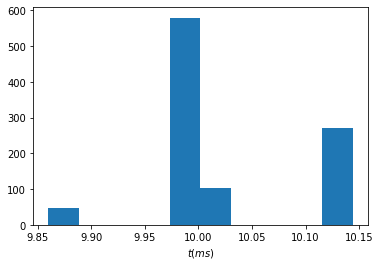

In [7]:
filename = "circuit_rc_auto.dat"  # Nom du fichier de données
with open(filename, 'r') as file:
    temps = np.loadtxt(file, delimiter=",", skiprows=1)  # On importe toutes les données en éliminant la ligne d'en-tête
    n_mesures = temps.size
    
# On passe en millisecondes le temps pour plus de lisibilité
temps = temps / 1000

""" Tracé de l'histogramme des valeurs de tau"""
f = figure(1)  # On crée une figure
ax1 = f.add_subplot(1, 1, 1)  # Création des axes du graphiques
ax1.hist(temps)  # Création de la courbe

ax1.set_xlabel(r"$t(ms)$")  # Légende des axes

Les valeurs étant peu dispersées. On va considérer qu'on ne peut repérer de mesure indiscutablement aberrantes. On garde donc toutes les mesures pour étude statistique sur les temps caractéristiques. On va donc:
* estimer la **valeur moyenne** des échantillons, ce sera l'estimation de $\tau$
* estimer l'écart-type associés à cette valeur moyenne, ce sera l'incertitude-type $u(\tau)$

## Estimation de $\tau$ puis de C.
L'incertitude sur tau est principalement dû aux décalage possible dans la mesure interne à Arduino.

On peut la majorer par le temps d'échantillonnage qui est d'environ 0.4 ms (estimé par une étude du comportement du micro-controlleur non présentée ici).

In [11]:
tau = mean(temps)
utauA = std(temps, ddof = 1)/ sqrt(n_mesures)  # On calcule l'incertitude de type A qu'on va composer avec l'incertitude évoquée précédemment.
utau = sqrt((0.4)**2 + utauA**2)
print ("tau = {:.1f} +/- {:.1f} ms".format(tau, utau))

tau = 10.0 +/- 0.4 ms


In [12]:
R = 1e5  # Valeur de la résistance
uR = 0.1 / 100 * R  # Le code couleur donne une incertitude de 0.1%
C = tau / R * 1e6  # On passe C en nanoFarad pour plus de lisibilité
uC = C *sqrt((uR / R)**2 + (utau/tau)**2)
print ("C = {:.0f} +/- {:.0f} nF".format(C, uC))
print("Valeur constructeur : 100 nF")

C = 100 +/- 4 nF
Valeur constructeur : 100 nF


**Analyse de la mesure** : La valeur mesurée est cohérente avec la valeur constructeur. On a pu obtenir une mesure relativement précise (4%) de la valeur de la capacitance.

On pourra remarquer que la principale source d'incertitude et donc de limitation dans la précision de la mesure de C est la période d'échantillonage du micro-controlleur. On est malheureusement à la limite des capacités de l'instrument. Pour améliorer la précision, il faudrait utiliser du matériel plus précis.

Notons par contre que l'utilisation du micro-controlleur a permis, en automatisant la mesure de $\tau$ de réaliser simplement une étude statistique basée sur 1000 mesures et non plus sur une seule.